# Modelling Purchase Probability

In this notebook, we explore how to model purchase probability i.e. whether a customer will buy a product from a specific product category when they enter a store. The main objective is to develop a statistical model which estimate purchase probability for each customer at each shopping trip based on historical data. 

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import plotly.express as px

sns.set(style='whitegrid')

In [2]:
segment_labels = pickle.load(open('models/segment-labels.pickle', 'rb'))
segment_colours = ['lightskyblue', 'red', 'gold', 'green']
segment_colour_palette = sns.color_palette(segment_colours)

In [3]:
def calc_elasticity_cross_point(df_data):
    return df_data[df_data['Elasticity'] < -1]['Price'].iloc[0]

def calc_elasticities_with_promotion(df: pd.DataFrame, promotion: int = 1, segment: int = None, price_range=(0.5, 3.5)):
    df_data = df.copy() if segment is None else df[df['Segment'] == segment].copy()
    
    # df_data['Avg_Promotion'] = (
    #    df_data['Promotion_1'] + df_data['Promotion_2'] +
    #    df_data['Promotion_3'] + df_data['Promotion_4'] +
    #    df_data['Promotion_5']) / 5
    
    X = np.array(df_data[['Avg_Price', 'Avg_Promotion']])
    y = np.array(df_data['Incidence'])
    
    # Fit a model
    lr = LogisticRegression(solver='sag')
    lr.fit(X, y)
    
    # Generate predictions for the chosen price range
    price_range_arr = np.arange(price_range[0], price_range[1], 0.01).reshape(-1, 1)
    promotion_arr = np.ones(price_range_arr.shape[0]).reshape(-1, 1) * promotion
    X_test = np.concatenate([price_range_arr, promotion_arr], axis=1)
    y_preds = lr.predict_proba(X_test)
    
    # Compute the price elasticities
    purchase_probability = y_preds[:,1].reshape(-1, 1)
    beta = lr.coef_.squeeze().item(0)  # Get the model coefficient for price
    price_elasticity = beta * price_range_arr * (1 - purchase_probability)

    # Create elasticity DataFrame
    elasticity_data = np.concatenate([price_range_arr, price_elasticity], axis=1)
    df_elasticities = pd.DataFrame(elasticity_data, columns=['Price', 'Elasticity'])

    return df_elasticities

def calc_elasticities_for_segment(df: pd.DataFrame, segment: int, price_range=(0.5, 3.5)):
    df_data = df[df['Segment'] == segment]
    x = np.array(df_data['Avg_Price']).reshape(-1, 1)
    y = np.array(df_data['Incidence'])
    
    # Fit a model
    lr = LogisticRegression(solver='sag')
    lr.fit(x, y)
    
    # Generate predictions for the chosen price range
    price_range_arr = np.arange(price_range[0], price_range[1], 0.01).reshape(-1, 1)
    y_preds = y_preds = lr.predict_proba(price_range_arr)
    
    # Compute the price elasticities
    purchase_probability = y_preds[:,1].reshape(-1, 1)
    beta = lr.coef_.squeeze().item(0)  # Get the model coefficient
    price_elasticity = beta * price_range_arr * (1 - purchase_probability)

    # Create elasticity DataFrame
    elasticity_data = np.concatenate([price_range_arr, price_elasticity], axis=1)
    df_elasticities = pd.DataFrame(elasticity_data, columns=['Price', 'Elasticity'])
    
    inelasticty_end = df_elasticities[df_elasticities['Elasticity'] < -1]['Price'].iloc[0]
    
    return df_elasticities

## Logistic Regression Model

Backed by research, we build a simple model where the assumption is that the purchase probability is influenced by the average price of a product.

In [4]:
df_purchases = pd.read_csv('data/fmcg-store-purchases-augmented.csv', index_col=0)

In [5]:
df_purchases['Avg_Price'] = (
    df_purchases['Price_1'] + df_purchases['Price_2'] +
    df_purchases['Price_3'] + df_purchases['Price_4'] +
    df_purchases['Price_5']) / 5

In [6]:
x = np.array(df_purchases['Avg_Price']).reshape(-1, 1)
y = np.array(df_purchases['Incidence'])

In [7]:
lr = LogisticRegression(solver='sag')
lr.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

Let us look at the slope of the linear model:

In [8]:
lr.coef_

array([[-2.34856916]])

So there is an inverse proportionality between price and purchase probability. The coefficient of the independent variable tells us that a decrease in the average price will lead to an increase in purchase probability. This does not come as a surprise. The model quantifies the exact relationship between price and purchase probability.




## Price Elasticity

Price elasticity of purchase probability is the percentage change in purchase probability in response to a 1% change in the respective aggregate price for the product category.

Per definition, elasticity measure the percentage change in the output variable (in this case purchase probability)
given a 1% change in the input variable (in our case the average price). If percent change is greater than 100%,
then the output (the purchase probability) is elastic. For changes less than 100%, it is inelastic. 
In other words, if $|E| < 1$ i.e. the absolute elasticity value is smaller than 1 then it is **inelastic**, 
otherwise it is elastic. 

The general recommendation is to increase the price, for price points which are inelastic because it would not cause a significant decrease in the output variable (purchase probability). On the other hand, if a price point is elastic, then we should decrease the price.

Calculating the price elasticity can help us answer this question:

> How does demand for the product change with the given change in price?

The elasticity can be calculated as follows:
\begin{align}
E
&=
\frac{
  \Delta Pr(purchase) / Pr(purchase)
}{
  \Delta Price / Price
}
=
\frac{
  \Delta Pr(purchase)
}{
  \Delta Price
}
\cdot
\frac{
  Price
}{
  Pr(purchase)
}\\
&=
\beta \cdot Price \cdot(1 - Pr(purchase))
\end{align}
where $\beta$ is the coefficient of the model.

We can analyse a range of values for the mean price and determine how they effect the purchase probability. The range of prices can be determined by looking at the dataset.

In [9]:
df_purchases[[f'Price_{i}' for i in range(1, 6)]].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


The minimum price is 1.1 and maximum price is 2.8. We can extend this range to [0.5, 3.5] because it allows us to gain a better understanding of how the purchase probabilities and corresponding elasticity change. A big enough range may give us valuable information.

In [10]:
price_range = np.arange(0.5, 3.5, 0.01).reshape(-1, 1)

We will use the simple model to generate predictions for the price range.

In [11]:
y_preds = lr.predict_proba(price_range)

In [12]:
# Compute the price elasticities
beta = lr.coef_.squeeze().item(0)
purchase_probability = y_preds[:,1].reshape(-1, 1)
price_elasticity = beta * price_range * (1 - purchase_probability)

# Create elasticity DataFrame
elasticity_data = np.concatenate([price_range, price_elasticity], axis=1)
df_elasticities = pd.DataFrame(elasticity_data, columns=['Price', 'Elasticity'])

In [13]:
df_elasticities.head()

,Price,Elasticity
0,0.50,-0.096399
1,0.51,-0.100467
2,0.52,-0.104663
3,0.53,-0.108989
4,0.54,-0.113448


To spot patterns, let us graph the price elasticities.

In [14]:
inelasticty_end = df_elasticities[df_elasticities['Elasticity'] < -1]['Price'].iloc[0]

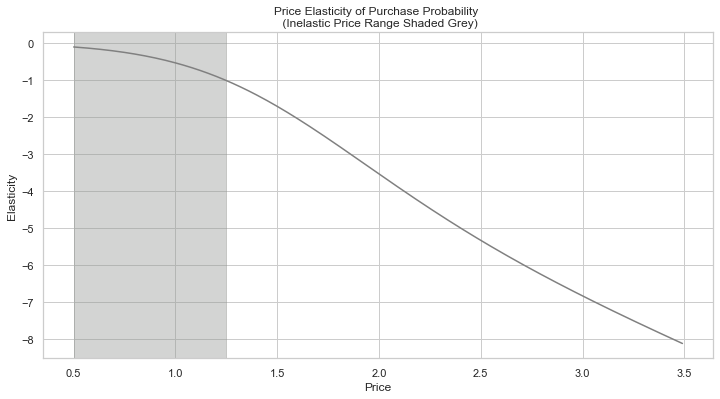

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_elasticities, color='grey', ax=ax)
ax.axvspan(0.5, inelasticty_end, color=sns.xkcd_rgb['grey'], alpha=0.4)
ax.set_title('Price Elasticity of Purchase Probability \n (Inelastic Price Range Shaded Grey)');

The price elasticity decreases as the price increase i.e. the higher the price, the less likely for purchase. 
This is obvious. The interesting is the rate. The decrease is relatively slow in the range 0.5 to around 1.5, 
and then it becomes steeper. 

The price elasticities are all negative. This is because we used the model's coefficient which was negative.
So there was an inverse proportionality between price and purchase probability.

We can determine whether or not different price points are elastic or not. For example, at the price point of 1.10, the average customer has an elasticity of -0.69. This means that for each increase in price by 1%, the probability of purchase will decrease by 0.69%. Since $|-0.69| < 1$, the purchase probability is inelastic. At 1.50 price point, the elasticity is -1.7. An increase of 1% in price would translate into decline of 1.7% of the purchase probability. In this case, the elasticity of purchase probability is elastic.

With prices lower than 1.25, we can increase them without losing too much in terms of purchase probability. For prices higher than 1.25, we gain more by reducing the prices.

The average customer elasticity curve is helpful to get an overview of the overall purchase behaviour. 
If we want to develop concrete marketing strategy, we need to further refine the analysis.
We can create finer analysis by looking at the specific behaviours of different consumer segments.

### Price Elasticity by Segment

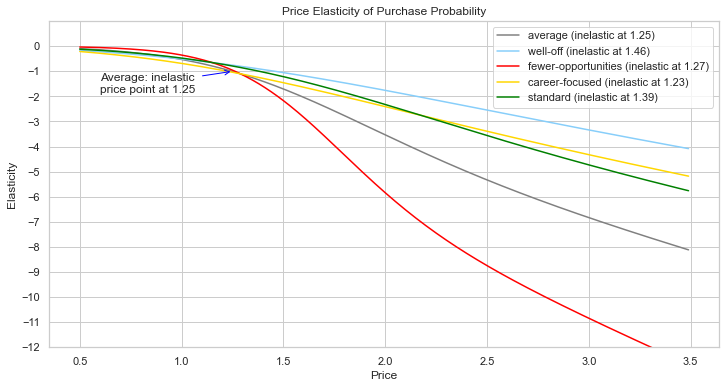

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_elasticities, label=f'average (inelastic at {inelasticty_end:.2f})', color='grey', ax=ax)
for segment, segment_label in segment_labels.items():
    df_data = calc_elasticities_for_segment(df_purchases, segment=segment)
    cross_point = calc_elasticity_cross_point(df_data)
    # annotation = f'{segment_label}: {cross_point:.2f}'
    # ax.annotate(annotation, xy=(cross_point, -1.0), xytext=(1.6,-0.2-(segment*0.15)))
    plot_label = f'{segment_label} (inelastic at {cross_point:.2f})'
    sns.lineplot(x='Price', y='Elasticity', data=df_data, color=segment_colours[segment], label=plot_label, ax=ax)
ax.set_yticks(np.arange(0, -15, -1))
ax.set_ylim([-12, 1])
arrow_props = dict(arrowstyle= '->',color='blue',lw=1, ls='-')
ax.annotate(f'Average: inelastic \nprice point at {inelasticty_end:.2f}', xy=(inelasticty_end, -1.0), xytext=(0.6,-1.5), arrowprops=arrow_props, va='center')
ax.set_title('Price Elasticity of Purchase Probability');

Showing all elasticity curves at the same time allows us to compare them:
- Standard segment becomes inelastic at price point 1.39. Notice it is 14 cents higher than the average price point. Suppose we want to target the Standard-segment. We could increase the price if the price of a product is between 0.5 to 1.39 and consider decreasing prices after 1.39.

- Fewer-Opportunities segment is more price sensitive compared to the average because its curve is both lower and much steeper than the other curves. For example, notice the large difference between the curves for Fewer-Opportunities and Well-Off segments. The steeper curve suggests that we increase the price, consumers become more elastic much faster. The tipping point between elasticity and inelasticity is 1.27. It appears that this segment is more inelastic in the lower than 1.27 price points. This is also evident from the graph where the red line a bit higher than the other curves. There are two factors that may explain this:
  1. The first reason is technical in nature. The Fewer-Opportunities segment contains the largest number of consumers. The abundance of data may result in a more sophisticated/better model.
  2. The second reason is related to purchasing behaviour. The consumers enjoy chocolate bars so much that a price increase in the lower price range does not affect them and would not stop them from buying the products. However, once it starts to become expensive then they consider it as a luxury product and avoid buying the product. 


## Purchase Probability with Promotion Feature

In any purchase analytics model, price is the most prominent feature. However, there are other factors such as promotion which effect customers' decision whether to buy a product. There are three types of promotions:
- **Price Reduction**: simply reduce the price of the product. It could be complex discounts conditioned on buying more units e.g. buy 2 and get 1 for free (get 33% discount).
- **Display**: product is situated in another selling location which is different from the usual place where consumers can pick it up. For example, placing a new car at a shopping mall is a promotion without a price reduction.
- **Feature**: promotions that happen when specific opportunities for product purchase are being distributed and presented to customers. For example, printed ads and newspaper inserts are feature promotions. Subtle feature promotions include using the same car brand in large movie productions like James Bond.

To consider the overall effect of promotion activities on price elasticity, we will look at two cases:
1. Promotional activities for all brands at all price points
2. No promotional activities

In [17]:
df_purchases['Avg_Promotion'] = (
    df_purchases['Promotion_1'] + df_purchases['Promotion_2'] +
    df_purchases['Promotion_3'] + df_purchases['Promotion_4'] +
    df_purchases['Promotion_5']) / 5

In [18]:
X = np.array(df_purchases[['Avg_Price', 'Avg_Promotion']])
y = np.array(df_purchases['Incidence'])

In [19]:
lr = LogisticRegression(solver='sag')
lr.fit(X, y)
lr.coef_

array([[-1.49408026,  0.56158995]])

The coefficients are -1.49 for price and 0.56 for promotion. The promotion coefficient is positive which indicates that if we increase the promotion, the purchase probability will increase. In broad terms, this is what we would expected. But the model quantifies the exact relationship between price, promotion and probability of purchase.

In [20]:
df_elasticities_with_promo = calc_elasticities_with_promotion(df_purchases, promotion=1, segment=None)
promo_cross_point = calc_elasticity_cross_point(df_elasticities_with_promo)
promo_label = f'With promotion (elastic after {promo_cross_point:.2f})'

df_elasticities_with_no_promo = calc_elasticities_with_promotion(df_purchases, promotion=0, segment=None)
no_promo_cross_point = calc_elasticity_cross_point(df_elasticities_with_no_promo)
no_promo_label = f'Without promotion (elastic after {no_promo_cross_point:.2f})'

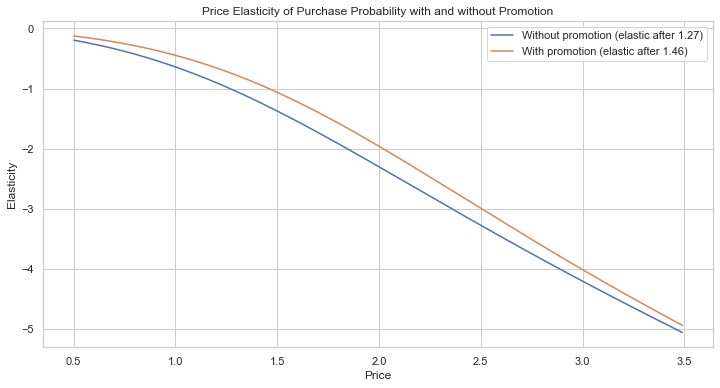

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_elasticities_with_no_promo, label=no_promo_label, ax=ax)
sns.lineplot(x='Price', y='Elasticity', data=df_elasticities_with_promo, label=promo_label, ax=ax)
ax.set_title('Price Elasticity of Purchase Probability with and without Promotion');

We observe that the elasticity curve with promotion sits above its no promotion counterpart for the entire price range. 
Without promotion, the price becomes elastic after the 1.27 price point, whereas with promotion it is 1.46.
The different is 19 cents. 
For example, if a product's regular price is 1.30, the purchase probability is elastic.
On the other hand, if a product costs 1.50 without promotion and is reduced to 1.30 during a promotion, 
then our analysis says that the purchase probability is still inelastic at 1.30. 
This sounds trivial. People are willing to buy products at promotional prices for several reasons.
Perhaps, psychologically people feel they are getting a bargain or it is due to the large discount signs in the stores.
In any case, customers are less price sensitive to similar price changes when there are promotional activities.
In other words, it pays off to offer discounts.

According to this model, it would be beneficial to have a higher original price and a constant promotion rather than a lower original price.